In [99]:
#calling initial necessities
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

from sklearn.preprocessing import MinMaxScaler

In [100]:
# pulling in data

SPCSV = pd.read_csv('Resources/^GSPC.csv')
SPCSV.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-05,2101.679932,2108.780029,2090.409912,2099.929932,2099.929932,4051890000
1,2015-11-06,2098.600098,2101.909912,2083.739990,2099.199951,2099.199951,4369020000
2,2015-11-09,2096.560059,2096.560059,2068.239990,2078.580078,2078.580078,3882350000
3,2015-11-10,2077.189941,2083.669922,2069.909912,2081.719971,2081.719971,3821440000
4,2015-11-11,2083.409912,2086.939941,2074.850098,2075.000000,2075.000000,3692410000


In [101]:
#adjusting date to make it friendly

SPCSV["Date"] = pd.to_datetime(SPCSV.Date,format="%Y-%m-%d")
SPCSV.index = SPCSV['Date']


In [102]:
# Assign the data to X and y (opening and closing values)
# Note: Sklearn requires a two-dimensional array of values
# so we use reshape to create this

X = SPCSV.Date.values.reshape(-1, 1)
y = SPCSV.Close.values.reshape(-1, 1)

print("Shape: ", X.shape, y.shape)
X

Shape:  (1259, 1) (1259, 1)


array([['2015-11-05T00:00:00.000000000'],
       ['2015-11-06T00:00:00.000000000'],
       ['2015-11-09T00:00:00.000000000'],
       ...,
       ['2020-11-02T00:00:00.000000000'],
       ['2020-11-03T00:00:00.000000000'],
       ['2020-11-04T00:00:00.000000000']], dtype='datetime64[ns]')

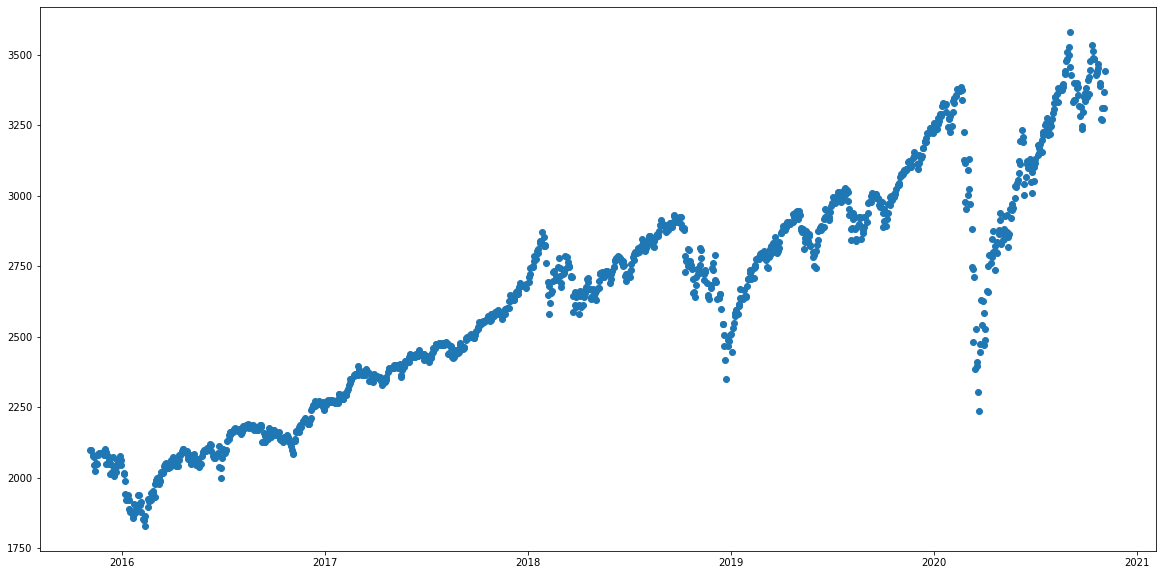

In [103]:
# Plot the data
plt.scatter(X, y)


In [104]:
# Create the model and fit the model to the data

from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [105]:
#fitting model to data
model.fit(X, y)


LinearRegression()

In [106]:
# Print the coefficient and the intercept for the model

print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_)

Weight coefficients:  [[8.26580976e-15]]
y-axis intercept:  [-9975.46863596]


In [107]:
print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_)

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])
print(f"Min X Value: {x_min}")
print(f"Max X Value: {x_max}")
y_min = np.array([[y.min()]])
y_max = np.array([[y.max()]])
print(f"Min y Value: {y_min}")
print(f"Max y Value: {y_max}")

Weight coefficients:  [[8.26580976e-15]]
y-axis intercept:  [-9975.46863596]
Min X Value: [['2015-11-05T00:00:00.000000000']]
Max X Value: [['2020-11-04T00:00:00.000000000']]
Min y Value: [[1829.079956]]
Max y Value: [[3580.840088]]


Text(0, 0.5, 'Stock Price ($)')

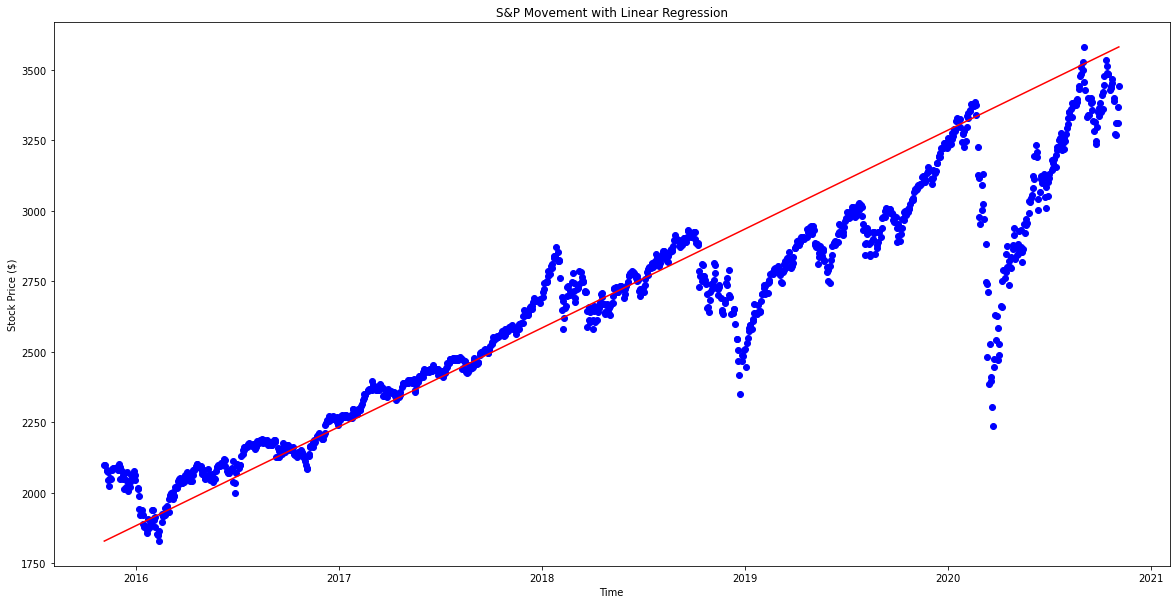

In [108]:
plt.scatter(X, y, c='blue')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')
plt.title("S&P Movement with Linear Regression")
plt.xlabel("Time")
plt.ylabel("Stock Price ($)")

In [109]:
#skimming down table to essentials
data = SPCSV.sort_index(ascending=True,axis=0)
new_SPCSV = pd.DataFrame(index=range(0,len(SPCSV)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_SPCSV["Date"][i] = data['Date'][i]
    new_SPCSV["Close"][i]= data["Close"][i]

new_SPCSV.head()

,Date,Close
0,2015-11-05 00:00:00,2099.93
1,2015-11-06 00:00:00,2099.2
2,2015-11-09 00:00:00,2078.58
3,2015-11-10 00:00:00,2081.72
4,2015-11-11 00:00:00,2075


In [110]:
#normalizing data

scaler = MinMaxScaler(feature_range = (0,1))
final_SPCSV = new_SPCSV.values

train_SPCSV = final_SPCSV[0:987,:]
valid_SPCSV = final_SPCSV[987:,:]

In [111]:
new_SPCSV.index = new_SPCSV.Date
new_SPCSV.drop("Date",axis=1, inplace=True)
new_SPCSV.head()

,Close
Date,
2015-11-05,2099.93
2015-11-06,2099.2
2015-11-09,2078.58
2015-11-10,2081.72
2015-11-11,2075


In [112]:
scaler = MinMaxScaler(feature_range=(0,1))
#importing datetime to make this work
#import datetime as dt
#from datetime import datetime
#final_SPCSV = final_SPCSV["Date"].astype(str)
scaled_SPCSV = scaler.fit_transform(new_SPCSV)
print(scaled_SPCSV)
#this would not work when i tried using final_SPCSV as i was struggling to convert timestamp, but i don't think
#that affects the values, it was just a cleaner

[[0.1546159 ]
 [0.15419919]
 [0.14242825]
 ...
 [0.84552674]
 [0.87916144]
 [0.92156452]]


In [113]:
X_train_SPCSV, y_train_SPCSV = [],[]

for i in range(60,len(train_SPCSV)):
    X_train_SPCSV.append(scaled_SPCSV[i-60:i,0])
    y_train_SPCSV.append(scaled_SPCSV[i,0])

In [114]:
X_train_SPCSV, y_train_SPCSV = np.array(X_train_SPCSV),np.array(y_train_SPCSV)

X_train_SPCSV = np.reshape(X_train_SPCSV,(X_train_SPCSV.shape[0],X_train_SPCSV.shape[1],1))

In [115]:
#building LSTM model

lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences = True, input_shape=(X_train_SPCSV.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))


In [116]:
#run time
inputs_SPCSV = new_SPCSV
inputs_SPCSV=new_SPCSV[len(new_SPCSV)-len(valid_SPCSV)-60:].values
inputs_SPCSV=inputs_SPCSV.reshape(-1,1)
inputs_SPCSV=scaler.transform(inputs_SPCSV)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(X_train_SPCSV,y_train_SPCSV,epochs=50,batch_size=1,verbose=2)

Epoch 1/50
927/927 - 40s - loss: 0.0027
Epoch 2/50
927/927 - 35s - loss: 8.5538e-04
Epoch 3/50
927/927 - 37s - loss: 5.8725e-04
Epoch 4/50
927/927 - 36s - loss: 5.2247e-04
Epoch 5/50
927/927 - 40s - loss: 4.2798e-04
Epoch 6/50
927/927 - 44s - loss: 3.3992e-04
Epoch 7/50
927/927 - 44s - loss: 3.6182e-04
Epoch 8/50
927/927 - 46s - loss: 2.5790e-04
Epoch 9/50
927/927 - 37s - loss: 2.8301e-04
Epoch 10/50
927/927 - 36s - loss: 2.8471e-04
Epoch 11/50
927/927 - 38s - loss: 2.8261e-04
Epoch 12/50
927/927 - 37s - loss: 2.5819e-04
Epoch 13/50
927/927 - 36s - loss: 2.3861e-04
Epoch 14/50
927/927 - 38s - loss: 2.6129e-04
Epoch 15/50
927/927 - 37s - loss: 2.5201e-04
Epoch 16/50
927/927 - 36s - loss: 2.2467e-04
Epoch 17/50
927/927 - 39s - loss: 2.4576e-04
Epoch 18/50
927/927 - 35s - loss: 2.4431e-04
Epoch 19/50
927/927 - 34s - loss: 2.2253e-04
Epoch 20/50
927/927 - 34s - loss: 2.3445e-04
Epoch 21/50
927/927 - 33s - loss: 2.1490e-04
Epoch 22/50
927/927 - 35s - loss: 2.3166e-04
Epoch 23/50
927/927 - 3

In [117]:
#sampling to make predictions
X_test=[]
for i in range(60,inputs_SPCSV.shape[0]):
    X_test.append(inputs_SPCSV[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

In [118]:
#saving model and csv
modelprediction = pd.DataFrame(predicted_closing_price, columns=['predicted_closing_price']).to_csv('modelprediction.csv')
lstm_model.save("saved_model.h5")

/Applications/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


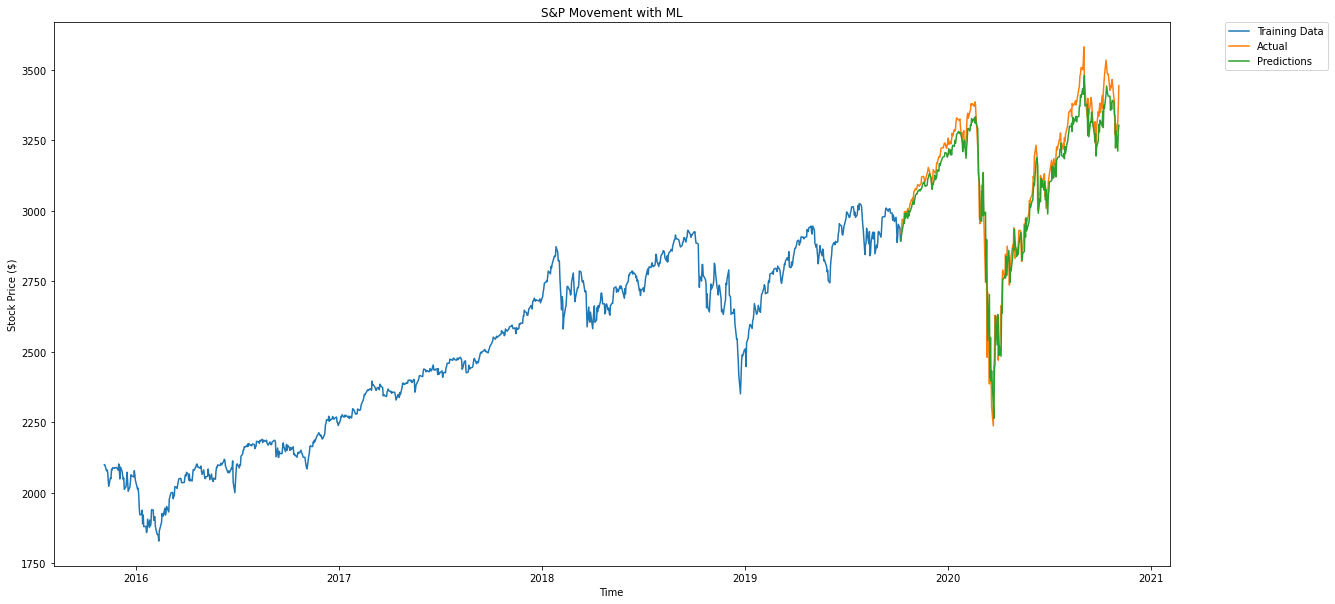

In [119]:
#visualization of prediction vs actual
train_data=new_SPCSV[:987]
valid_data=new_SPCSV[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"], label="Training Data")
plt.plot(valid_data["Close"], label="Actual")
plt.plot(valid_data['Predictions'], label = "Predictions")
plt.title("S&P Movement with ML")
plt.xlabel("Time")
plt.ylabel("Stock Price ($)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


In [120]:
#pred = []

#x = np.array().reshape(x.shape[0],1)
#x = [[2919.399902], [y], [z]] # last true data
#x.append([100])
#deque(maxlen=60)
#for i in range(365):
#    prediction = lstm_model.predict([x])
#    pred.append(prediction)
#    x.append()
#    x.pop(0)

In [121]:
#scoring model
from math import sqrt
from sklearn.metrics import mean_squared_error

#print(inputs_SPCSV)
#print(X_test)
#print(predicted_closing_price)
#print(valid_data["Close"])
rmse = sqrt(mean_squared_error(valid_data["Close"], predicted_closing_price))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 68.796


In [122]:
#Repeating process for individual stocks

AppleCSV = pd.read_csv('Resources/AAPL.csv')

AppleCSV["Date"] = pd.to_datetime(AppleCSV.Date,format="%Y-%m-%d")
AppleCSV.index = AppleCSV['Date']

AppleCSV.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2015-11-09,2015-11-09,30.240000,30.452499,30.012501,30.142500,27.926165,135485600
2015-11-10,2015-11-10,29.225000,29.517500,29.014999,29.192499,27.046017,236511600
2015-11-11,2015-11-11,29.092501,29.355000,28.802500,29.027500,26.893150,180872000
2015-11-12,2015-11-12,29.065001,29.205000,28.912500,28.930000,26.802820,130102400
2015-11-13,2015-11-13,28.799999,28.892500,28.067499,28.084999,26.019947,183249600


In [123]:
GoogleCSV = pd.read_csv('Resources/GOOG.csv')

GoogleCSV["Date"] = pd.to_datetime(GoogleCSV.Date,format="%Y-%m-%d")
GoogleCSV.index = GoogleCSV['Date']

GoogleCSV.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2015-11-05,2015-11-05,729.469971,739.479980,729.469971,731.250000,731.250000,1861600
2015-11-06,2015-11-06,731.500000,735.409973,727.010010,733.760010,733.760010,1511600
2015-11-09,2015-11-09,730.200012,734.710022,719.429993,724.890015,724.890015,2069800
2015-11-10,2015-11-10,724.400024,730.590027,718.500000,728.320007,728.320007,1608000
2015-11-11,2015-11-11,732.460022,741.000000,730.229980,735.400024,735.400024,1366400


In [124]:
TeslaCSV = pd.read_csv('Resources/TSLA.csv')

TeslaCSV["Date"] = pd.to_datetime(TeslaCSV.Date,format="%Y-%m-%d")
TeslaCSV.index = TeslaCSV['Date']

TeslaCSV.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2015-11-05,2015-11-05,46.116001,46.916000,45.838001,46.354000,46.354000,22484000
2015-11-06,2015-11-06,46.139999,46.672001,45.900002,46.472000,46.472000,12226500
2015-11-09,2015-11-09,46.598000,46.598000,44.862000,45.066002,45.066002,19254500
2015-11-10,2015-11-10,44.695999,44.740002,43.216000,43.299999,43.299999,23085000
2015-11-11,2015-11-11,43.554001,43.896000,42.726002,43.816002,43.816002,16739000


In [125]:
MicrosoftCSV = pd.read_csv('Resources/MSFT.csv')

MicrosoftCSV["Date"] = pd.to_datetime(MicrosoftCSV.Date,format="%Y-%m-%d")
MicrosoftCSV.index = MicrosoftCSV['Date']

MicrosoftCSV.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2015-11-05,2015-11-05,54.490002,54.700001,54.000000,54.380001,49.420284,31468500
2015-11-06,2015-11-06,54.090000,54.980000,53.959999,54.919998,49.911034,32851200
2015-11-09,2015-11-09,54.549999,54.869999,53.560001,54.160000,49.220352,32513100
2015-11-10,2015-11-10,54.070000,54.130001,53.270000,53.509998,48.629631,55283700
2015-11-11,2015-11-11,53.700001,54.200001,53.459999,53.650002,48.756870,36516300


In [126]:
BPCSV = pd.read_csv('Resources/BP.csv')

BPCSV["Date"] = pd.to_datetime(BPCSV.Date,format="%Y-%m-%d")
BPCSV.index = BPCSV['Date']

BPCSV.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2015-11-05,2015-11-05,35.900002,36.189999,35.529999,35.549999,25.425489,6416400
2015-11-06,2015-11-06,35.020000,35.369999,34.779999,35.130001,25.125107,5852300
2015-11-09,2015-11-09,35.139999,35.389999,34.689999,34.880001,24.946301,5727900
2015-11-10,2015-11-10,34.619999,35.009998,34.529999,34.770000,24.867632,4717000
2015-11-11,2015-11-11,34.770000,34.849998,34.349998,34.389999,24.595858,4630200


Shape:  (1259, 1) (1259, 1)


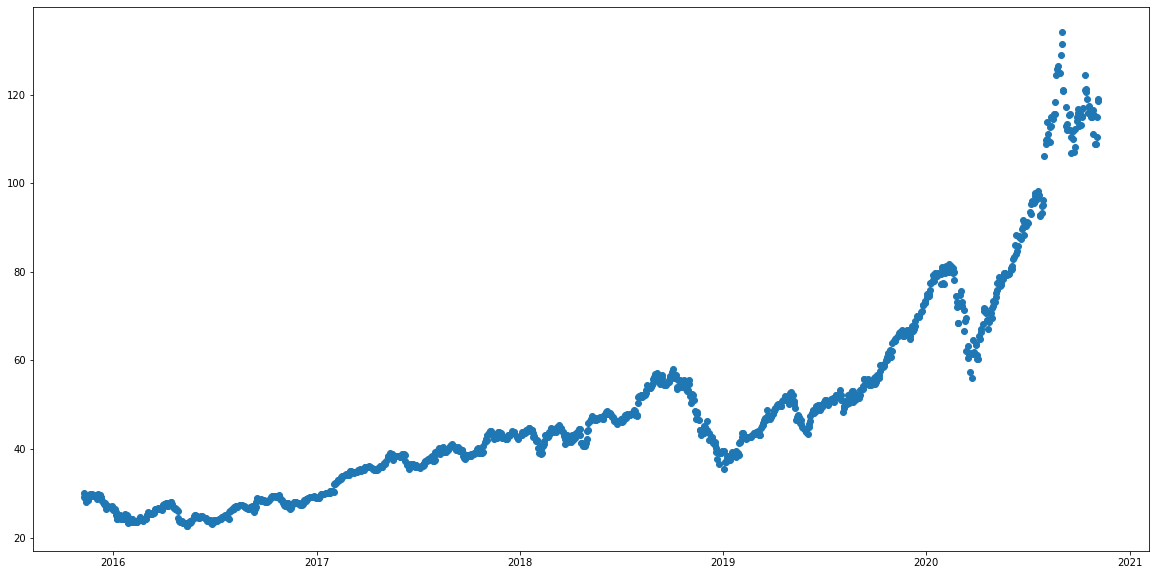

In [127]:
AppleX = AppleCSV.Date.values.reshape(-1, 1)
Appley = AppleCSV.Close.values.reshape(-1, 1)
print("Shape: ", AppleX.shape, Appley.shape)
plt.scatter(AppleX, Appley)

Shape:  (1258, 1) (1258, 1)


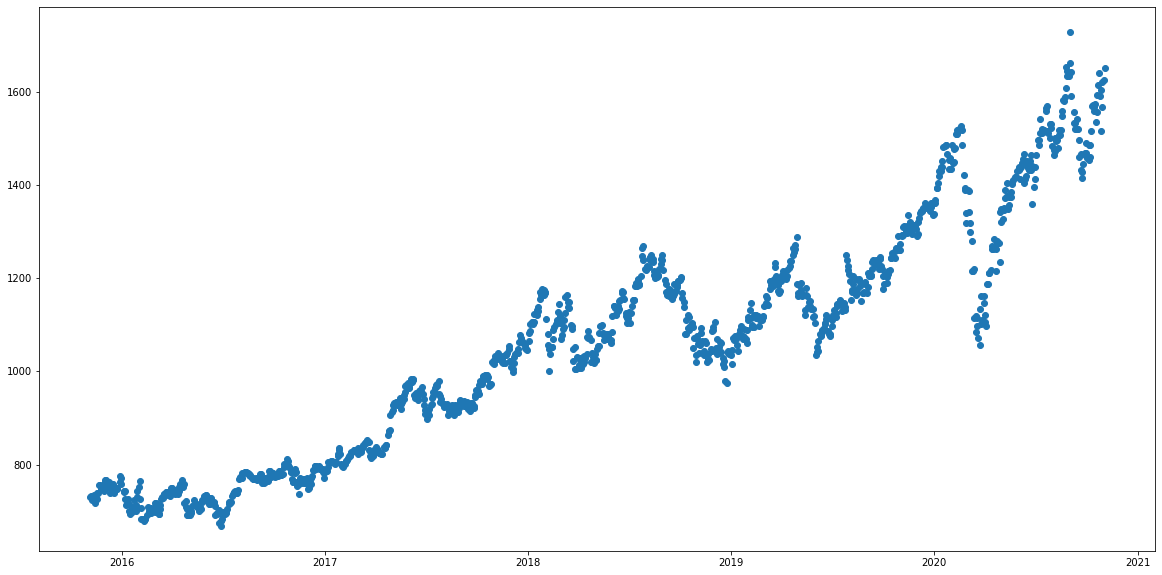

In [128]:
GoogleX = GoogleCSV.Date.values.reshape(-1, 1)
Googley = GoogleCSV.Close.values.reshape(-1, 1)
print("Shape: ", GoogleX.shape, Googley.shape)
plt.scatter(GoogleX, Googley)

Shape:  (1258, 1) (1258, 1)


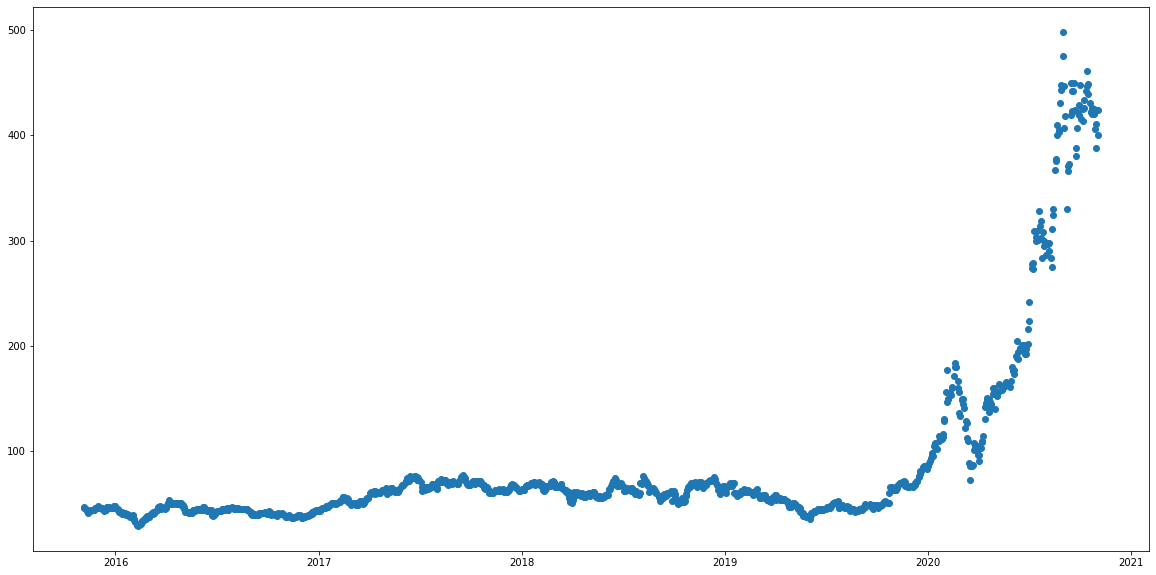

In [129]:
TeslaX = TeslaCSV.Date.values.reshape(-1, 1)
Teslay = TeslaCSV.Close.values.reshape(-1, 1)
print("Shape: ", TeslaX.shape, Teslay.shape)
plt.scatter(TeslaX, Teslay)

Shape:  (1258, 1) (1258, 1)


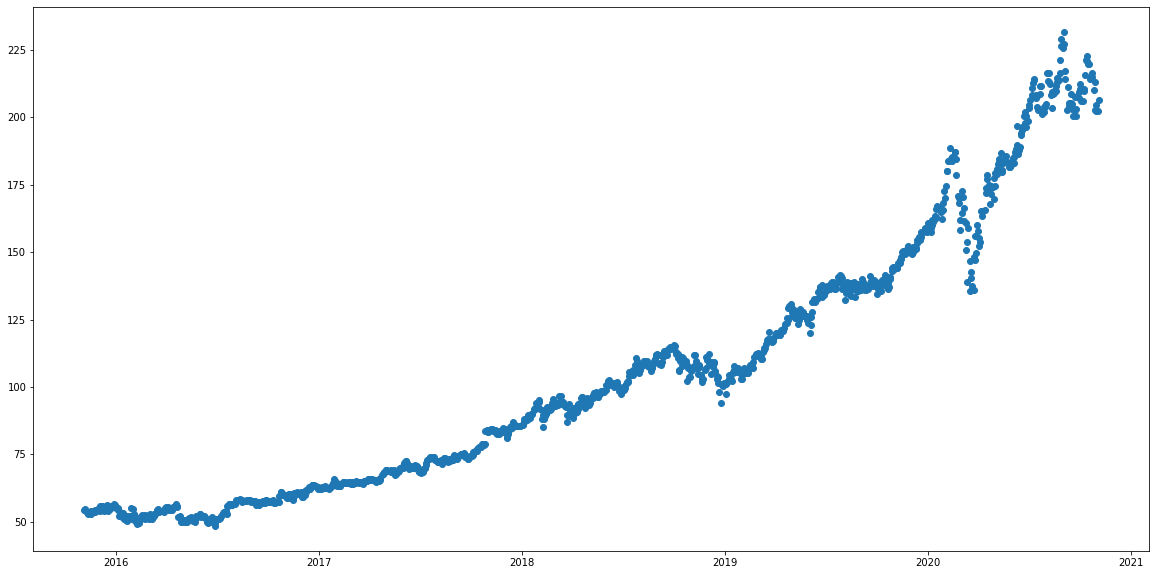

In [130]:
MicrosoftX = MicrosoftCSV.Date.values.reshape(-1, 1)
Microsofty = MicrosoftCSV.Close.values.reshape(-1, 1)
print("Shape: ", MicrosoftX.shape, Microsofty.shape)
plt.scatter(MicrosoftX, Microsofty)

Shape:  (1258, 1) (1258, 1)


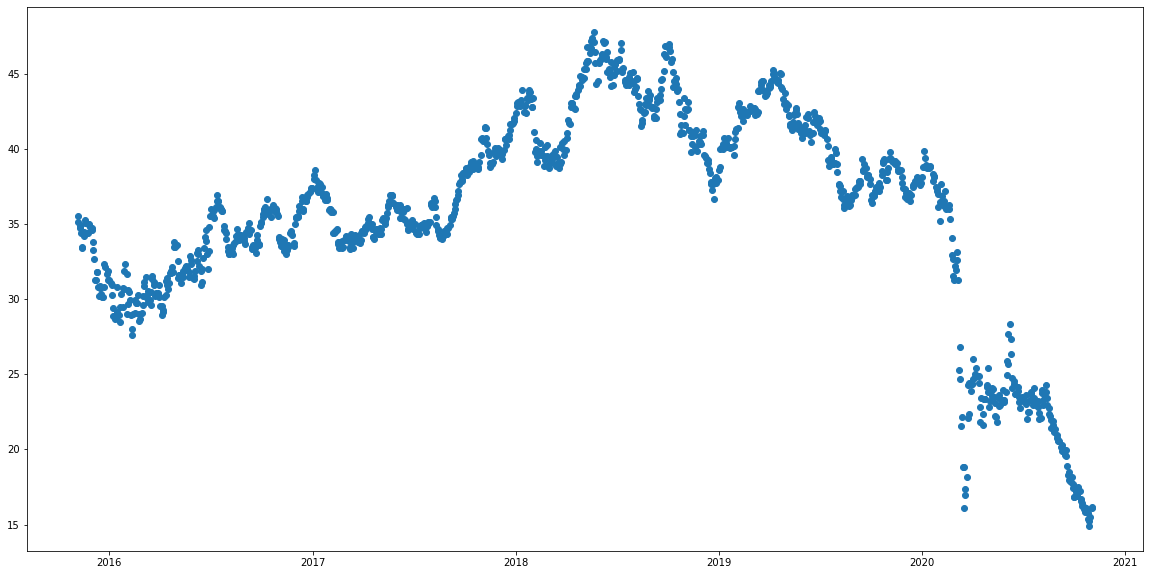

In [131]:
BPX = BPCSV.Date.values.reshape(-1, 1)
BPy = BPCSV.Close.values.reshape(-1, 1)
print("Shape: ", BPX.shape, BPy.shape)
plt.scatter(BPX, BPy)

Weight coefficients:  [[4.38833836e-16]]
y-axis intercept:  [-620.69314476]
Min X Value: [['2015-11-09T00:00:00.000000000']]
Max X Value: [['2020-11-06T00:00:00.000000000']]
Min X Value: [['2015-11-09T00:00:00.000000000']]
Max X Value: [['2020-11-06T00:00:00.000000000']]


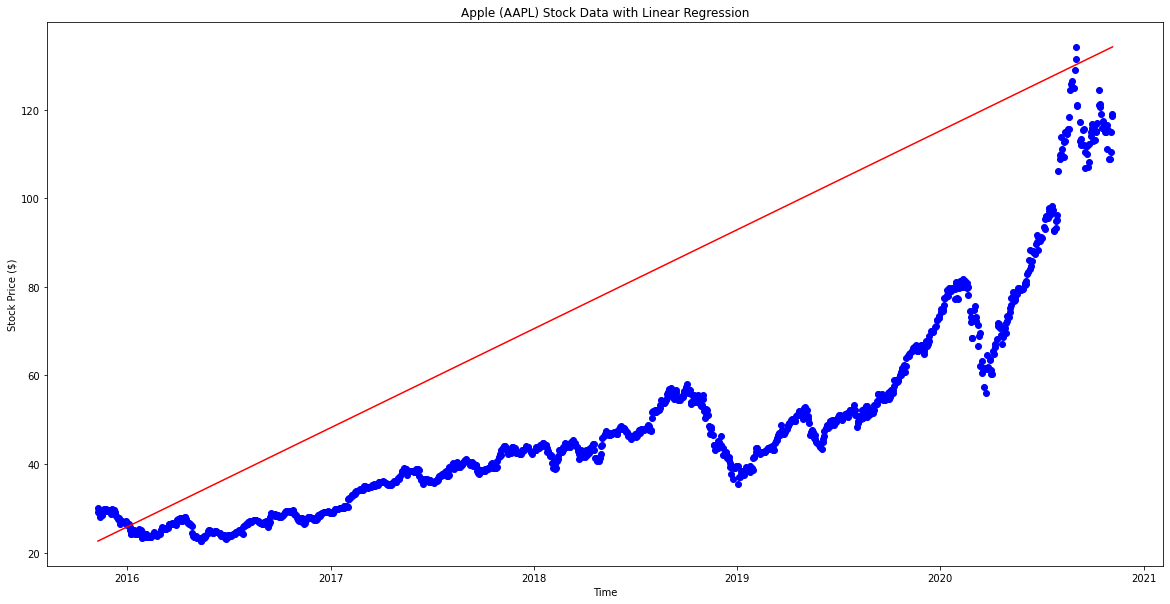

In [132]:
Applemodel = LinearRegression()
Applemodel.fit(AppleX, Appley)
print('Weight coefficients: ', Applemodel.coef_)
print('y-axis intercept: ', Applemodel.intercept_)

Applex_min = np.array([[AppleX.min()]])
Applex_max = np.array([[AppleX.max()]])
print(f"Min X Value: {Applex_min}")
print(f"Max X Value: {Applex_max}")
Appley_min = np.array([[Appley.min()]])
Appley_max = np.array([[Appley.max()]])
print(f"Min X Value: {Applex_min}")
print(f"Max X Value: {Applex_max}")

plt.scatter(AppleX, Appley, c='blue')
plt.title("Apple (AAPL) Stock Data with Linear Regression")
plt.xlabel("Time")
plt.ylabel("Stock Price ($)")
plt.plot([Applex_min[0], Applex_max[0]], [Appley_min[0], Appley_max[0]], c='red')

Weight coefficients:  [[5.11992877e-15]]
y-axis intercept:  [-6753.29728711]
Min X Value: [['2015-11-05T00:00:00.000000000']]
Max X Value: [['2020-11-03T00:00:00.000000000']]
Min X Value: [['2015-11-05T00:00:00.000000000']]
Max X Value: [['2020-11-03T00:00:00.000000000']]


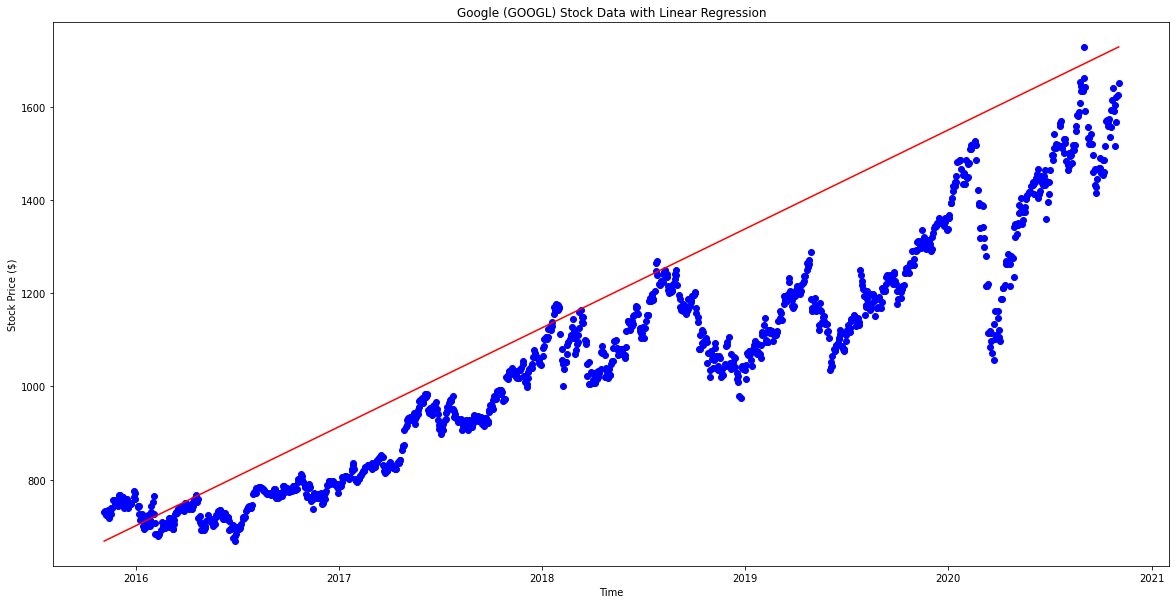

In [133]:
Googlemodel = LinearRegression()
Googlemodel.fit(GoogleX, Googley)
print('Weight coefficients: ', Googlemodel.coef_)
print('y-axis intercept: ', Googlemodel.intercept_)

Googlex_min = np.array([[GoogleX.min()]])
Googlex_max = np.array([[GoogleX.max()]])
print(f"Min X Value: {Googlex_min}")
print(f"Max X Value: {Googlex_max}")
Googley_min = np.array([[Googley.min()]])
Googley_max = np.array([[Googley.max()]])
print(f"Min X Value: {Googlex_min}")
print(f"Max X Value: {Googlex_max}")

plt.scatter(GoogleX, Googley, c='blue')
plt.title("Google (GOOGL) Stock Data with Linear Regression")
plt.xlabel("Time")
plt.ylabel("Stock Price ($)")
plt.plot([Googlex_min[0], Googlex_max[0]], [Googley_min[0], Googley_max[0]], c='red')

Weight coefficients:  [[1.12682761e-15]]
y-axis intercept:  [-1632.77430825]
Min X Value: [['2015-11-05T00:00:00.000000000']]
Max X Value: [['2020-11-03T00:00:00.000000000']]
Min X Value: [['2015-11-05T00:00:00.000000000']]
Max X Value: [['2020-11-03T00:00:00.000000000']]


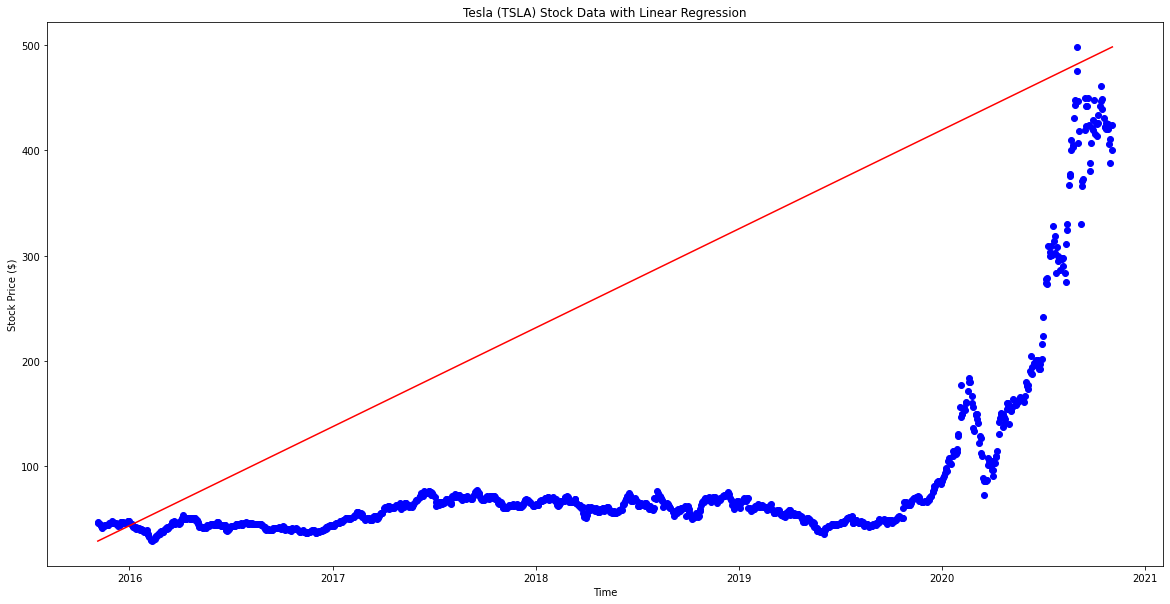

In [134]:
Teslamodel = LinearRegression()
Teslamodel.fit(TeslaX, Teslay)
print('Weight coefficients: ', Teslamodel.coef_)
print('y-axis intercept: ', Teslamodel.intercept_)

Teslax_min = np.array([[TeslaX.min()]])
Teslax_max = np.array([[TeslaX.max()]])
print(f"Min X Value: {Teslax_min}")
print(f"Max X Value: {Teslax_max}")
Teslay_min = np.array([[Teslay.min()]])
Teslay_max = np.array([[Teslay.max()]])
print(f"Min X Value: {Teslax_min}")
print(f"Max X Value: {Teslax_max}")

plt.scatter(TeslaX, Teslay, c='blue')
plt.title("Tesla (TSLA) Stock Data with Linear Regression")
plt.xlabel("Time")
plt.ylabel("Stock Price ($)")
plt.plot([Teslax_min[0], Teslax_max[0]], [Teslay_min[0], Teslay_max[0]], c='red')

Weight coefficients:  [[9.94864028e-16]]
y-axis intercept:  [-1412.48383047]
Min X Value: [['2015-11-05T00:00:00.000000000']]
Max X Value: [['2020-11-03T00:00:00.000000000']]
Min X Value: [['2015-11-05T00:00:00.000000000']]
Max X Value: [['2020-11-03T00:00:00.000000000']]


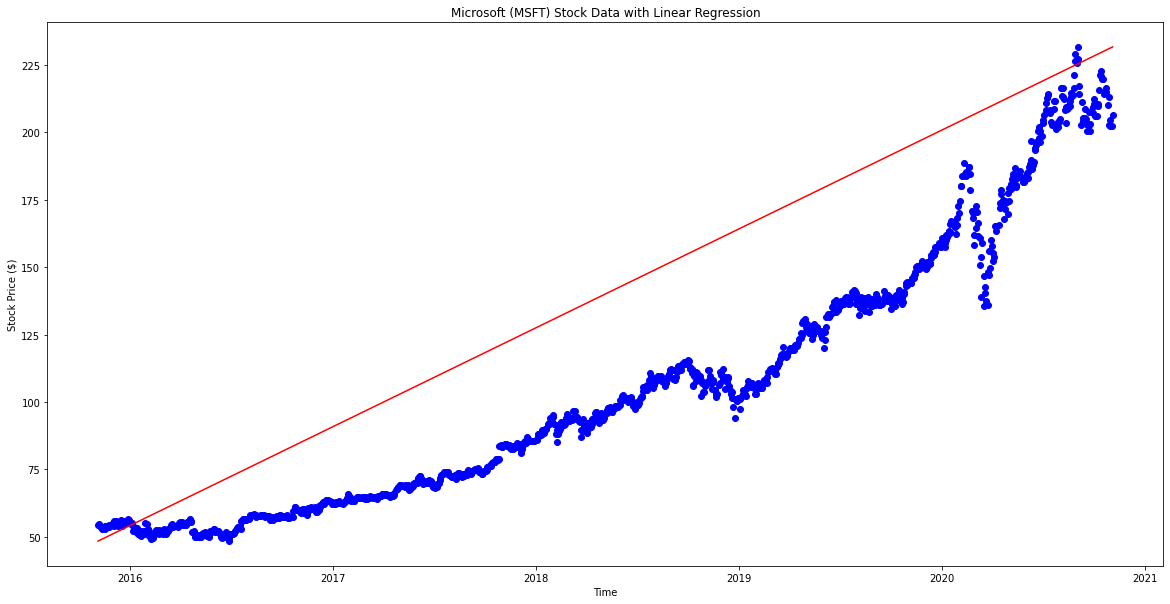

In [135]:
Microsoftmodel = LinearRegression()
Microsoftmodel.fit(MicrosoftX, Microsofty)
print('Weight coefficients: ', Microsoftmodel.coef_)
print('y-axis intercept: ', Microsoftmodel.intercept_)

Microsoftx_min = np.array([[MicrosoftX.min()]])
Microsoftx_max = np.array([[MicrosoftX.max()]])
print(f"Min X Value: {Microsoftx_min}")
print(f"Max X Value: {Microsoftx_max}")
Microsofty_min = np.array([[Microsofty.min()]])
Microsofty_max = np.array([[Microsofty.max()]])
print(f"Min X Value: {Microsoftx_min}")
print(f"Max X Value: {Microsoftx_max}")

plt.scatter(MicrosoftX, Microsofty, c='blue')
plt.title("Microsoft (MSFT) Stock Data with Linear Regression")
plt.xlabel("Time")
plt.ylabel("Stock Price ($)")
plt.plot([Microsoftx_min[0], Microsoftx_max[0]], [Microsofty_min[0], Microsofty_max[0]], c='red')

Weight coefficients:  [[-2.44304363e-17]]
y-axis intercept:  [72.99265172]
Min X Value: [['2015-11-05T00:00:00.000000000']]
Max X Value: [['2020-11-03T00:00:00.000000000']]
Min X Value: [['2015-11-05T00:00:00.000000000']]
Max X Value: [['2020-11-03T00:00:00.000000000']]


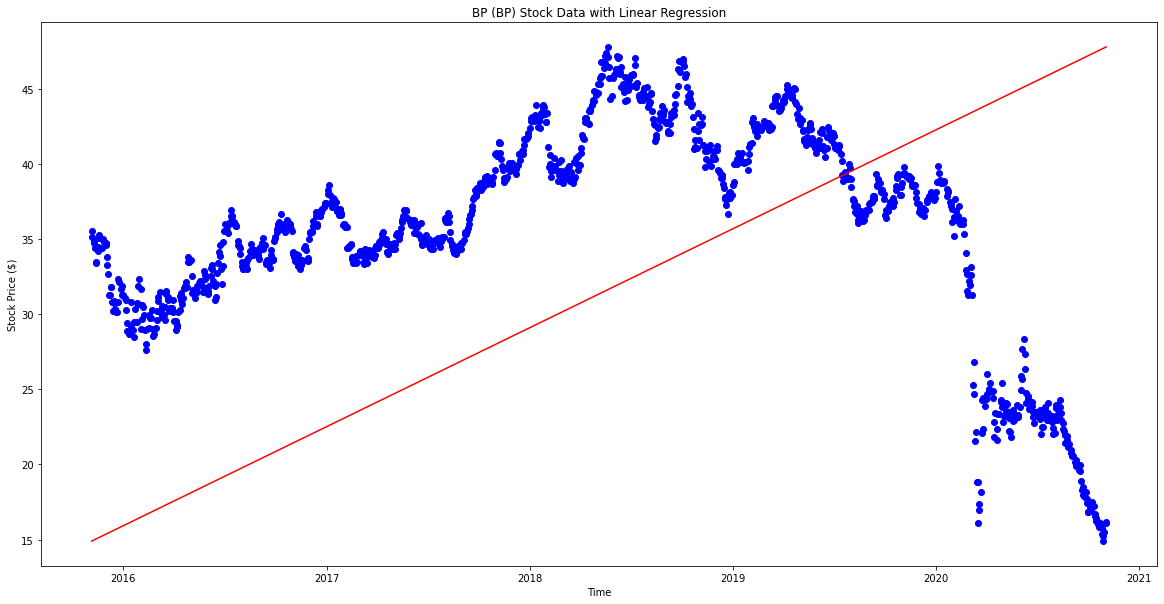

In [136]:
BPmodel = LinearRegression()
BPmodel.fit(BPX, BPy)
print('Weight coefficients: ', BPmodel.coef_)
print('y-axis intercept: ', BPmodel.intercept_)

BPx_min = np.array([[BPX.min()]])
BPx_max = np.array([[BPX.max()]])
print(f"Min X Value: {BPx_min}")
print(f"Max X Value: {BPx_max}")
BPy_min = np.array([[BPy.min()]])
BPy_max = np.array([[BPy.max()]])
print(f"Min X Value: {BPx_min}")
print(f"Max X Value: {BPx_max}")

plt.scatter(BPX, BPy, c='blue')
plt.title("BP (BP) Stock Data with Linear Regression")
plt.xlabel("Time")
plt.ylabel("Stock Price ($)")
plt.plot([BPx_min[0], BPx_max[0]], [BPy_min[0], BPy_max[0]], c='red')

In [137]:
Appledata = AppleCSV.sort_index(ascending=True,axis=0)
new_AppleCSV = pd.DataFrame(index=range(0,len(AppleCSV)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_AppleCSV["Date"][i] = Appledata['Date'][i]
    new_AppleCSV["Close"][i]= Appledata["Close"][i]

new_AppleCSV.head()

,Date,Close
0,2015-11-09 00:00:00,30.1425
1,2015-11-10 00:00:00,29.1925
2,2015-11-11 00:00:00,29.0275
3,2015-11-12 00:00:00,28.93
4,2015-11-13 00:00:00,28.085


In [138]:
scaler = MinMaxScaler(feature_range = (0,1))
final_AppleCSV = new_AppleCSV.values

valid_AppleCSV = final_SPCSV[:,:]

new_AppleCSV.index = new_AppleCSV.Date
new_AppleCSV.drop("Date",axis=1, inplace=True)
new_AppleCSV.head()

scaled_AppleCSV = scaler.fit_transform(new_AppleCSV)

In [139]:
inputs_AppleCSV = new_AppleCSV
inputs_AppleCSV=new_AppleCSV.values
inputs_AppleCSV=inputs_AppleCSV.reshape(-1,1)
inputs_AppleCSV=scaler.transform(inputs_AppleCSV)
print(inputs_AppleCSV)

[[0.06772258]
 [0.05920965]
 [0.05773109]
 ...
 [0.82768048]
 [0.86424128]
 [0.86119457]]


In [140]:
AppleX_test=[]
for i in range(60,inputs_AppleCSV.shape[0]):
    AppleX_test.append(inputs_AppleCSV[i-60:i,0])
AppleX_test=np.array(AppleX_test)

AppleX_test=np.reshape(AppleX_test,(AppleX_test.shape[0],AppleX_test.shape[1],1))
Applepredicted_closing_price=lstm_model.predict(AppleX_test)
Applepredicted_closing_price=scaler.inverse_transform(Applepredicted_closing_price)

In [141]:
Appleprediction = pd.DataFrame(Applepredicted_closing_price, columns=['Applepredicted_closing_price']).to_csv('Appleprediction.csv')

/Applications/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


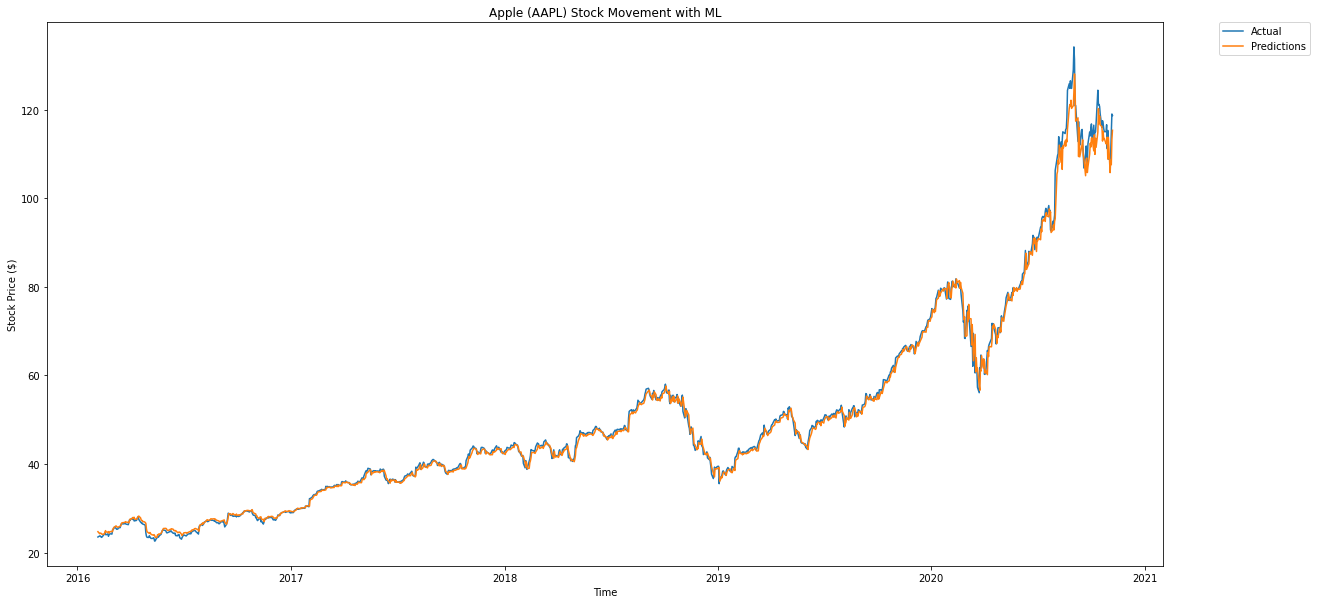

In [142]:
Apple_valid_data=new_AppleCSV[60:]

Apple_valid_data['Predictions']=Applepredicted_closing_price
plt.plot(Apple_valid_data["Close"], label="Actual")
plt.plot(Apple_valid_data['Predictions'], label = "Predictions")
plt.title("Apple (AAPL) Stock Movement with ML")
plt.xlabel("Time")
plt.ylabel("Stock Price ($)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [143]:
Googledata = GoogleCSV.sort_index(ascending=True,axis=0)
new_GoogleCSV = pd.DataFrame(index=range(0,len(GoogleCSV)),columns=['Date','Close'])

for i in range(0,len(data)-1):
    new_GoogleCSV["Date"][i] = Googledata['Date'][i]
    new_GoogleCSV["Close"][i]= Googledata["Close"][i]

new_GoogleCSV.head()

,Date,Close
0,2015-11-05 00:00:00,731.25
1,2015-11-06 00:00:00,733.76
2,2015-11-09 00:00:00,724.89
3,2015-11-10 00:00:00,728.32
4,2015-11-11 00:00:00,735.4


In [144]:
scaler = MinMaxScaler(feature_range = (0,1))
final_GoogleCSV = new_GoogleCSV.values

valid_GoogleCSV = final_GoogleCSV[:,:]

new_GoogleCSV.index = new_GoogleCSV.Date
new_GoogleCSV.drop("Date",axis=1, inplace=True)
new_GoogleCSV.head()

scaled_GoogleCSV = scaler.fit_transform(new_GoogleCSV)

In [145]:
inputs_GoogleCSV = new_GoogleCSV
inputs_GoogleCSV=new_GoogleCSV.values
inputs_GoogleCSV=inputs_GoogleCSV.reshape(-1,1)
inputs_GoogleCSV=scaler.transform(inputs_GoogleCSV)
print(inputs_GoogleCSV)

[[0.0594234 ]
 [0.06179129]
 [0.05342352]
 ...
 [0.89880378]
 [0.90353956]
 [0.92635038]]


In [146]:
GoogleX_test=[]
for i in range(60,inputs_GoogleCSV.shape[0]):
    GoogleX_test.append(inputs_GoogleCSV[i-60:i,0])
GoogleX_test=np.array(GoogleX_test)

GoogleX_test=np.reshape(GoogleX_test,(GoogleX_test.shape[0],GoogleX_test.shape[1],1))
Googlepredicted_closing_price=lstm_model.predict(GoogleX_test)
Googlepredicted_closing_price=scaler.inverse_transform(Googlepredicted_closing_price)

In [147]:
Googleprediction = pd.DataFrame(Googlepredicted_closing_price, columns=['Googlepredicted_closing_price']).to_csv('Googleprediction.csv')

/Applications/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


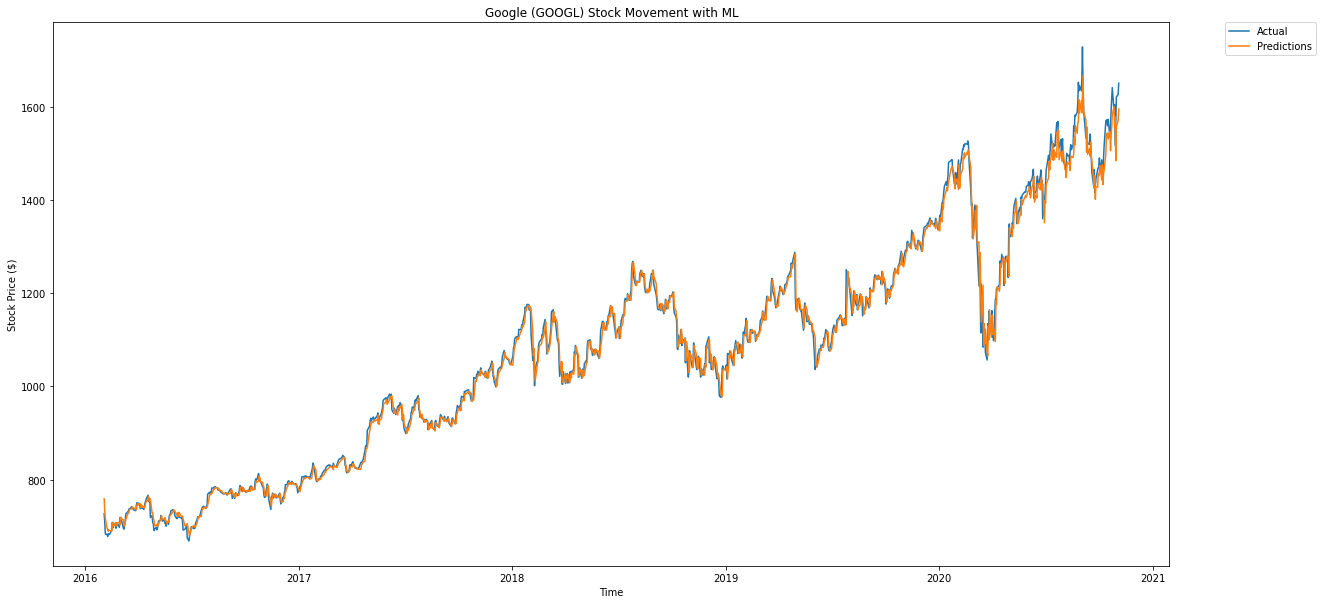

In [148]:
Google_valid_data=new_GoogleCSV[60:]

Google_valid_data['Predictions']=Googlepredicted_closing_price
plt.plot(Google_valid_data["Close"], label="Actual")
plt.plot(Google_valid_data['Predictions'], label = "Predictions")
plt.title("Google (GOOGL) Stock Movement with ML")
plt.xlabel("Time")
plt.ylabel("Stock Price ($)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [149]:
Tesladata = TeslaCSV.sort_index(ascending=True,axis=0)
new_TeslaCSV = pd.DataFrame(index=range(0,len(TeslaCSV)),columns=['Date','Close'])

for i in range(0,len(data)-1):
    new_TeslaCSV["Date"][i] = Tesladata['Date'][i]
    new_TeslaCSV["Close"][i]= Tesladata["Close"][i]

new_TeslaCSV.head()

,Date,Close
0,2015-11-05 00:00:00,46.354
1,2015-11-06 00:00:00,46.472
2,2015-11-09 00:00:00,45.066
3,2015-11-10 00:00:00,43.3
4,2015-11-11 00:00:00,43.816


In [150]:
scaler = MinMaxScaler(feature_range = (0,1))
final_TeslaCSV = new_TeslaCSV.values

valid_TeslaCSV = final_TeslaCSV[:,:]

new_TeslaCSV.index = new_TeslaCSV.Date
new_TeslaCSV.drop("Date",axis=1, inplace=True)
new_TeslaCSV.head()

scaled_TeslaCSV = scaler.fit_transform(new_TeslaCSV)

In [151]:
inputs_TeslaCSV = new_TeslaCSV
inputs_TeslaCSV=new_TeslaCSV.values
inputs_TeslaCSV=inputs_TeslaCSV.reshape(-1,1)
inputs_TeslaCSV=scaler.transform(inputs_TeslaCSV)
print(inputs_TeslaCSV)

[[0.03752241]
 [0.0377737 ]
 [0.03477958]
 ...
 [0.76515485]
 [0.79171015]
 [0.84151995]]


In [152]:
TeslaX_test=[]
for i in range(60,inputs_TeslaCSV.shape[0]):
    TeslaX_test.append(inputs_TeslaCSV[i-60:i,0])
TeslaX_test=np.array(TeslaX_test)

TeslaX_test=np.reshape(TeslaX_test,(TeslaX_test.shape[0],TeslaX_test.shape[1],1))
Teslapredicted_closing_price=lstm_model.predict(TeslaX_test)
Teslapredicted_closing_price=scaler.inverse_transform(Teslapredicted_closing_price)

In [153]:
Teslaprediction = pd.DataFrame(Teslapredicted_closing_price, columns=['Teslapredicted_closing_price']).to_csv('Teslaprediction.csv')

/Applications/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


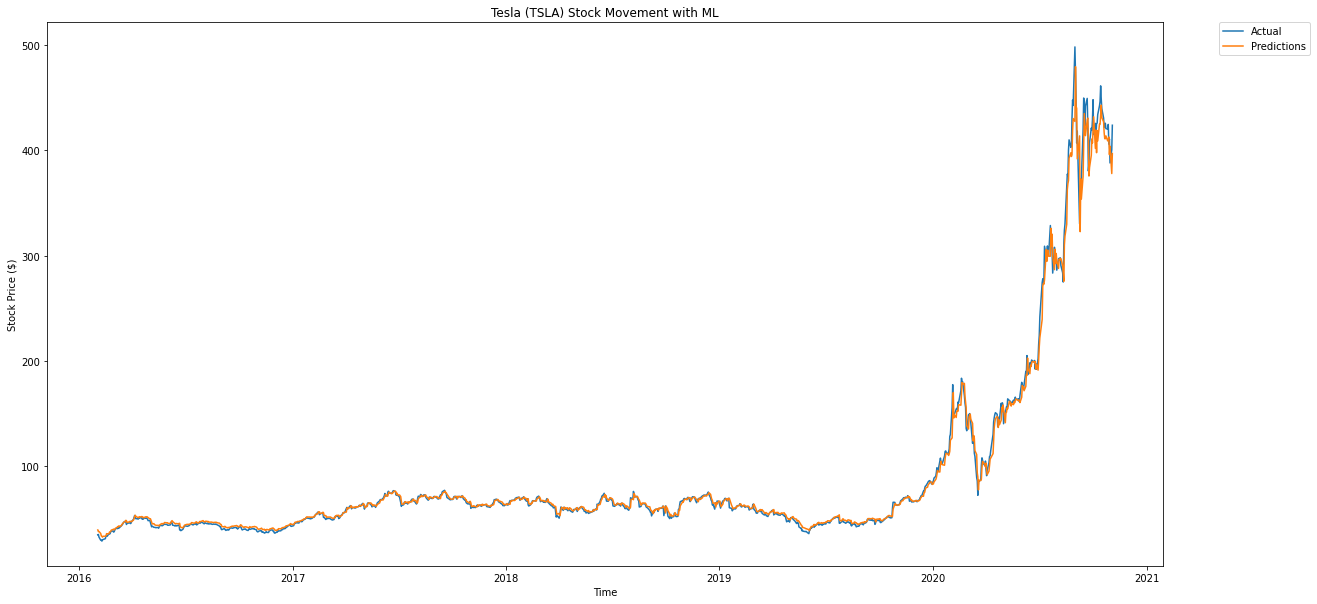

In [154]:
Tesla_valid_data=new_TeslaCSV[60:]

Tesla_valid_data['Predictions']=Teslapredicted_closing_price
plt.plot(Tesla_valid_data["Close"], label="Actual")
plt.plot(Tesla_valid_data['Predictions'], label = "Predictions")
plt.title("Tesla (TSLA) Stock Movement with ML")
plt.xlabel("Time")
plt.ylabel("Stock Price ($)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [155]:
Microsoftdata = MicrosoftCSV.sort_index(ascending=True,axis=0)
new_MicrosoftCSV = pd.DataFrame(index=range(0,len(MicrosoftCSV)),columns=['Date','Close'])

for i in range(0,len(data)-1):
    new_MicrosoftCSV["Date"][i] = Microsoftdata['Date'][i]
    new_MicrosoftCSV["Close"][i]= Microsoftdata["Close"][i]

new_MicrosoftCSV.head()

,Date,Close
0,2015-11-05 00:00:00,54.38
1,2015-11-06 00:00:00,54.92
2,2015-11-09 00:00:00,54.16
3,2015-11-10 00:00:00,53.51
4,2015-11-11 00:00:00,53.65


In [156]:
scaler = MinMaxScaler(feature_range = (0,1))
final_MicrosoftCSV = new_MicrosoftCSV.values

valid_MicrosoftCSV = final_MicrosoftCSV[:,:]

new_MicrosoftCSV.index = new_MicrosoftCSV.Date
new_MicrosoftCSV.drop("Date",axis=1, inplace=True)
new_MicrosoftCSV.head()

scaled_MicrosoftCSV = scaler.fit_transform(new_MicrosoftCSV)

In [157]:
inputs_MicrosoftCSV = new_MicrosoftCSV
inputs_MicrosoftCSV=new_MicrosoftCSV.values
inputs_MicrosoftCSV=inputs_MicrosoftCSV.reshape(-1,1)
inputs_MicrosoftCSV=scaler.transform(inputs_MicrosoftCSV)
print(inputs_MicrosoftCSV)

[[0.03247463]
 [0.03542189]
 [0.03127388]
 ...
 [0.84073794]
 [0.83997384]
 [0.86235126]]


In [158]:
MicrosoftX_test=[]
for i in range(60,inputs_MicrosoftCSV.shape[0]):
    MicrosoftX_test.append(inputs_MicrosoftCSV[i-60:i,0])
MicrosoftX_test=np.array(MicrosoftX_test)

MicrosoftX_test=np.reshape(MicrosoftX_test,(MicrosoftX_test.shape[0],MicrosoftX_test.shape[1],1))
Microsoftpredicted_closing_price=lstm_model.predict(MicrosoftX_test)
Microsoftpredicted_closing_price=scaler.inverse_transform(Microsoftpredicted_closing_price)

In [159]:
Microsoftprediction = pd.DataFrame(Microsoftpredicted_closing_price, columns=['Microsoftpredicted_closing_price']).to_csv('Microsoftprediction.csv')

/Applications/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


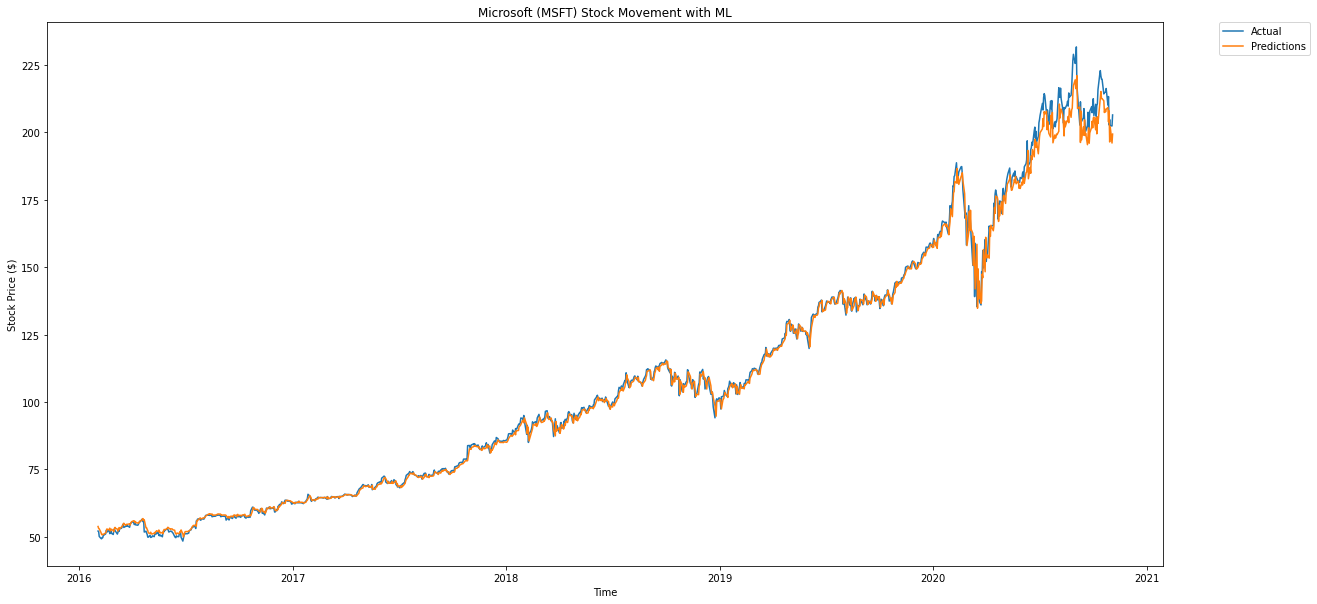

In [160]:
Microsoft_valid_data=new_MicrosoftCSV[60:]

Microsoft_valid_data['Predictions']=Microsoftpredicted_closing_price
plt.plot(Microsoft_valid_data["Close"], label="Actual")
plt.plot(Microsoft_valid_data['Predictions'], label = "Predictions")
plt.title("Microsoft (MSFT) Stock Movement with ML")
plt.xlabel("Time")
plt.ylabel("Stock Price ($)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [161]:
BPdata = BPCSV.sort_index(ascending=True,axis=0)
new_BPCSV = pd.DataFrame(index=range(0,len(BPCSV)),columns=['Date','Close'])

for i in range(0,len(data)-1):
    new_BPCSV["Date"][i] = BPdata['Date'][i]
    new_BPCSV["Close"][i]= BPdata["Close"][i]

new_BPCSV.head()

,Date,Close
0,2015-11-05 00:00:00,35.55
1,2015-11-06 00:00:00,35.13
2,2015-11-09 00:00:00,34.88
3,2015-11-10 00:00:00,34.77
4,2015-11-11 00:00:00,34.39


In [162]:
scaler = MinMaxScaler(feature_range = (0,1))
final_BPCSV = new_BPCSV.values

valid_BPCSV = final_BPCSV[:,:]

new_BPCSV.index = new_BPCSV.Date
new_BPCSV.drop("Date",axis=1, inplace=True)
new_BPCSV.head()

scaled_BPCSV = scaler.fit_transform(new_BPCSV)

In [163]:
inputs_BPCSV = new_BPCSV
inputs_BPCSV=new_BPCSV.values
inputs_BPCSV=inputs_BPCSV.reshape(-1,1)
inputs_BPCSV=scaler.transform(inputs_BPCSV)
print(inputs_BPCSV)

[[0.62785036]
 [0.61508058]
 [0.60747949]
 ...
 [0.01763454]
 [0.03648525]
 [0.0389176 ]]


In [164]:
BPX_test=[]
for i in range(60,inputs_BPCSV.shape[0]):
    BPX_test.append(inputs_BPCSV[i-60:i,0])
BPX_test=np.array(BPX_test)

BPX_test=np.reshape(BPX_test,(BPX_test.shape[0],BPX_test.shape[1],1))
BPpredicted_closing_price=lstm_model.predict(BPX_test)
BPpredicted_closing_price=scaler.inverse_transform(BPpredicted_closing_price)

In [165]:
BPprediction = pd.DataFrame(BPpredicted_closing_price, columns=['BPpredicted_closing_price']).to_csv('BPprediction.csv')

/Applications/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


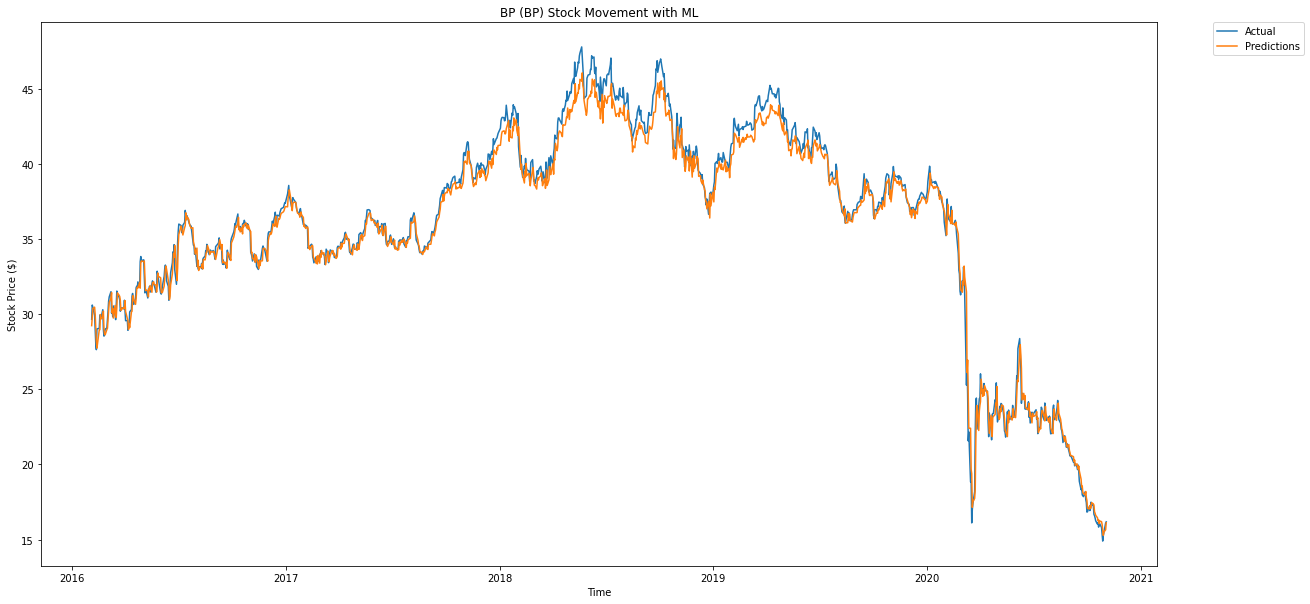

In [166]:
BP_valid_data=new_BPCSV[60:]

BP_valid_data['Predictions']=BPpredicted_closing_price
plt.plot(BP_valid_data["Close"], label="Actual")
plt.plot(BP_valid_data['Predictions'], label = "Predictions")
plt.title("BP (BP) Stock Movement with ML")
plt.xlabel("Time")
plt.ylabel("Stock Price ($)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)